### 有时候在存储图片的时候，我们会在清晰度和图片大小两方面进行进行均衡，对于某些情况下，我们可能会将一个清晰的图片转换成为一个相对不太清晰的图片，但是存储的图片大小会降低很多，这里介绍一种基于聚类算法的减小图片大小的方式，使用K-Means算法对图片进行聚类矢量化图片，从而达到图片压缩的效果

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from time import time
from scipy import misc

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

In [2]:
## 解决展示的时候中文乱码
matplotlib.rcParams['font.sans-serif'] = [u'SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
n_colors = 32 # 把图片中的颜色聚类为32类

In [11]:
## 读取图片，加载图片数据
image = Image.open('datas/xiaoren.png')  
#将数据转换为RGB的百分比
image = np.array(image, dtype=np.float64) / 255
print(image.shape)
#获取图片数据的维度/形状（长、宽、像素）
original_shape = tuple(image.shape)
print(original_shape)
shape_size = len(original_shape)
w, h, d = original_shape[0], original_shape[1], 1
# 如果是彩色的？
if shape_size == 3: 
    d = original_shape[2]
#将图片数据设置为二维的
image_v = np.reshape(image, (w * h, d))
image_v_sample = shuffle(image_v, random_state=28)[:10000]
# 打印颜色值
# 可以对颜色值进行聚类，聚类比较接近的颜色，共聚成32类，然后用32类的颜色来替代图片所有的颜色
# 颜色种类越多，图片像素越大，通过降低颜色种类，来降低图片大小
print(image_v_sample) 

(600, 510, 3)
(600, 510, 3)
[[ 1.          0.71372549  0.04705882]
 [ 1.          1.          1.        ]
 [ 0.          0.4627451   0.66666667]
 ..., 
 [ 0.01960784  0.37254902  0.61960784]
 [ 0.31372549  0.31372549  0.32156863]
 [ 1.          1.          1.        ]]


In [5]:
#算法构建
t0 = time()
k_means = KMeans(n_clusters=n_colors, random_state=28)
k_means.fit(image_v_sample)
print ("模型构建消耗时间:%.3fs" % (time() - t0))

模型构建消耗时间:2.343s


In [12]:
#进行算法数据预测，得到图片对应的所有的聚类类别信息
t0 = time()
labels = k_means.predict(image_v)
print ("算法模型预测消耗时间:%.3fs" % (time() - t0))
# 每个样本属于哪个类，结果显示前几个样本都属于0类
labels

算法模型预测消耗时间:0.247s


array([0, 0, 0, ..., 0, 0, 0])

In [7]:
#进行随机数据抽取，得到图片对象的聚类的类别信息
t0 = time()
codebook_random = shuffle(image_v, random_state=28)[:n_colors]# 随机排序
labels_random = pairwise_distances_argmin(image_v, codebook_random)# 计算一点和一组点之间的最小距离
print ("随机数据预测消耗时间:%.3fs" % (time() - t0))

随机数据预测消耗时间:0.277s


In [8]:
"""
重新构建一个图片数据(压缩图片数据)
codebook：各个类别的具体像素值集合(聚类中心/簇中心/类别中心)
labels：原始图片各个像素点的类别集合
w: 原始/新图片宽度
h：原始/新图片高度
"""
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

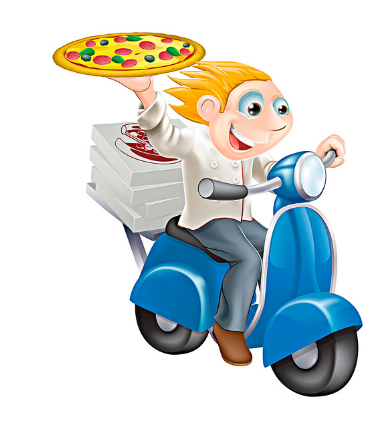

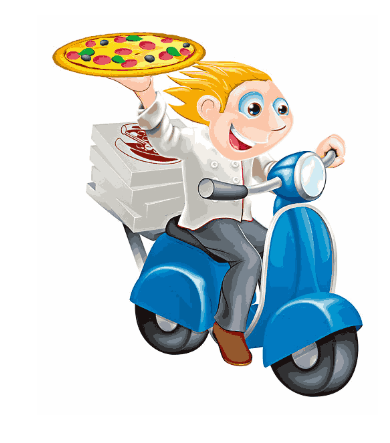

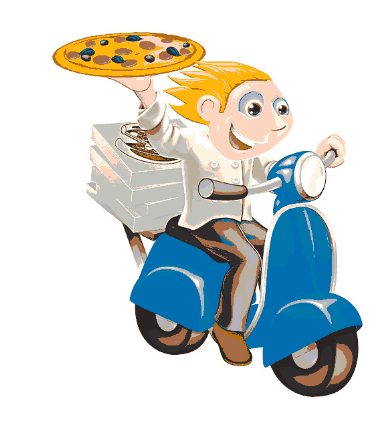

In [9]:
## 图片显示
plt.figure(u"原始图片",facecolor='w')
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
if d == 1:
    plt.imshow(image, cmap=plt.cm.gray)
else:
    plt.imshow(image)

plt.figure(u'K-Means算法压缩图片',facecolor='w') 
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
km_image = recreate_image(k_means.cluster_centers_, labels, w, h)
km_image.shape = original_shape
if d == 1:
    plt.imshow(km_image, cmap=plt.cm.gray)
else:
    plt.imshow(km_image)

plt.figure(u'随机抽取像素点压缩图片',facecolor='w')
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
random_image = recreate_image(codebook_random, labels_random, w, h)
random_image.shape = original_shape
if d == 1:
    plt.imshow(random_image, cmap=plt.cm.gray)
else:
    plt.imshow(random_image)
plt.show()

misc.imsave('datas/result_1.png', image) # 原图片
misc.imsave('datas/result_2.png', km_image) # 聚类图片
misc.imsave('datas/result_3.png', random_image) # 颜色随机赋值的图片